## FORECASTING OF STOCK PRICES USING MACHINE LEARNING METHODS

**INTRODUCTION**

This notebook contains the study of ML methods for stock price forecasting. The study is divided into 3 sections –
1. *Section 1: Analysis of different algorithms*<br>
   Algos such as SVR, RF regression, XGB regression and Linear regression are employed to predict stock prices for one month.
2. *Section 2: Experimenting with 'Close' Price and "Momentum" as target variable*<br>
   The algorithms were trained on closing price and 'momentum' (difference in price over a pre-determined period) to determine which gives better results.
3. *Section 3: How the number of features affect the results*<br>
    Several features were extracted from the data and the models were then trained on these feature-blocks (set of features containing certain information) to observe what kind of information helps in better predictions.  

**Dataset**

24 stocks from NSE, NASDAQ and LSE were taken which come from a diverse range of industry and market cap. The stock data for *7 years* from *March 2018* to *March 2025* were used to train the models. The forecastings were made for April 2025.

**The conclusion of the study is at the end of the notebook.**

## Section 1: Analysis of different algorithms

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae, root_mean_squared_error as rmse, r2_score as r2
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
df = yf.download("RELIANCE.NS", start="2018-03-01", end="2025-03-31")
df.head()

/tmp/ipykernel_55/1081633924.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("RELIANCE.NS", start="2018-03-01", end="2025-03-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2018-03-01,418.937714,424.017623,417.855474,419.534063,8956590
2018-03-05,408.203613,419.710702,407.099288,416.552327,12325694
2018-03-06,402.350708,413.548595,399.810768,410.368134,16019726
2018-03-07,393.030182,401.643927,392.279231,401.643927,15853546
2018-03-08,402.615723,403.963023,394.598327,396.519832,13283967


In [3]:
# cleaning the dataframe
df.columns = df.columns.droplevel(1)
df.columns.name = None
df.index.name = 'Date'
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2018-03-01,418.937714,424.017623,417.855474,419.534063,8956590
2018-03-05,408.203613,419.710702,407.099288,416.552327,12325694
2018-03-06,402.350708,413.548595,399.810768,410.368134,16019726
2018-03-07,393.030182,401.643927,392.279231,401.643927,15853546
2018-03-08,402.615723,403.963023,394.598327,396.519832,13283967


In [4]:
# separating features and target
X = df.drop(columns='Close')
y = df['Close']
print(X.head())
y.head()

                  High         Low        Open    Volume
Date                                                    
2018-03-01  424.017623  417.855474  419.534063   8956590
2018-03-05  419.710702  407.099288  416.552327  12325694
2018-03-06  413.548595  399.810768  410.368134  16019726
2018-03-07  401.643927  392.279231  401.643927  15853546
2018-03-08  403.963023  394.598327  396.519832  13283967


Date
2018-03-01    418.937714
2018-03-05    408.203613
2018-03-06    402.350708
2018-03-07    393.030182
2018-03-08    402.615723
Name: Close, dtype: float64

In [5]:
test = yf.download('RELIANCE.NS', start='2025-04-01', end='2025-04-30')
test.columns = test.columns.droplevel(1)
test.columns.name = None
test.index.name = 'Date'
test.head()

/tmp/ipykernel_55/77260974.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  test = yf.download('RELIANCE.NS', start='2025-04-01', end='2025-04-30')
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2025-04-01,1247.617065,1272.816469,1244.330266,1259.569329,12099648
2025-04-02,1246.172974,1250.555495,1238.951814,1242.587319,10142590
2025-04-03,1243.732666,1246.820432,1228.145018,1228.145018,7434366
2025-04-04,1199.907593,1240.495487,1188.403612,1236.162816,17908652
2025-04-07,1161.062744,1166.590715,1110.415052,1127.696009,22156106


In [6]:
y_true = test['Close']
X_test = test.drop(columns='Close')

### Linear Regression

In [7]:
reg = LinearRegression()
reg.fit(X,y)

LinearRegression()

In [8]:
y_pred_reg = reg.predict(X_test)
reg_mae = mae(y_true, y_pred_reg)
reg_rmse = rmse(y_true, y_pred_reg)
reg_r2 = r2(y_true, y_pred_reg)
print(f"MAE: {reg_mae}")
print(f"RMSE: {reg_rmse}")
print(f"R2: {reg_r2}")

MAE: 4.824802573359976
RMSE: 6.75384631049589
R2: 0.9872702942008112


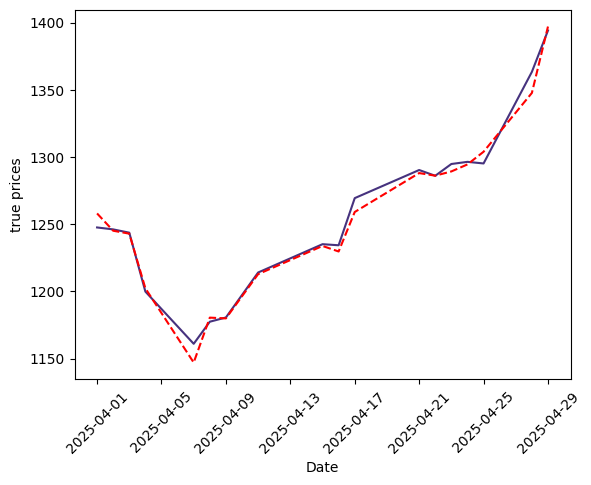

In [9]:
comp_lr = y_true.to_frame(name='true prices')
comp_lr['predictions'] = y_pred_reg
sns.set_palette('viridis')
sns.lineplot(data=comp_lr, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_lr, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### Support Vector Regression

In [8]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svr", SVR())
])
param_grid = {
    "svr__kernel": ["rbf"],
    "svr__C": [2.0 ** i for i in range(-5, 11)],
    "svr__epsilon": [2.0 ** i for i in range(-10, 1)],
    "svr__gamma": [2.0 ** i for i in range(-20, 11)]
}
print("C:", param_grid["svr__C"])
print("epsilon:", param_grid["svr__epsilon"])
print("gamma:", param_grid["svr__gamma"])

# time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(
    estimator=pipe,
    param_grid = param_grid,
    cv = tscv,
    scoring = 'neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X,y)

C: [0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0]
epsilon: [0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0]
gamma: [9.5367431640625e-07, 1.9073486328125e-06, 3.814697265625e-06, 7.62939453125e-06, 1.52587890625e-05, 3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625, 0.001953125, 0.00390625, 0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0, 1024.0]


In [11]:
best_svr = grid.best_estimator_
print("Best parameters:")
print(grid.best_params_)


Best parameters:
{'svr__C': 1024.0, 'svr__epsilon': 0.25, 'svr__gamma': 0.000244140625, 'svr__kernel': 'rbf'}


In [12]:
y_pred_svr = best_svr.predict(X_test)
svr_mae = mae(y_true, y_pred_svr)
svr_rmse = rmse(y_true, y_pred_svr)
svr_r2 = r2(y_true, y_pred_svr)
print(f"MAE: {svr_mae}")
print(f"RMSE: {svr_rmse}")
print(f"R2: {svr_r2}")

MAE: 12.524228510384559
RMSE: 15.031597109363968
R2: 0.936944020973364


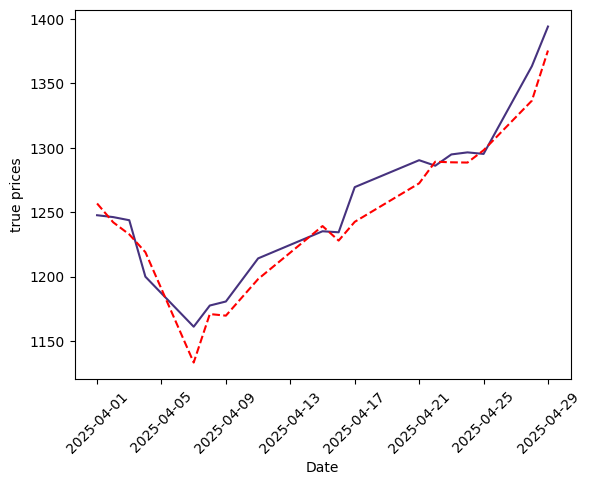

In [13]:
comp_svr = y_true.to_frame(name='true prices')
comp_svr['predictions'] = y_pred_svr
sns.set_palette('viridis')
sns.lineplot(data=comp_svr, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_svr, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### Random Forest

In [9]:
rf = RandomForestRegressor(
    random_state=100,
    n_jobs=-1    
)
param_grid = {
    "n_estimators":[200,300,500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,5,10],
    "max_features": ['sqrt', 0.5]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
grid_rf.fit(X,y)
y_pred_rf = grid_rf.predict(X_test)
rf_mae = mae(y_true, y_pred_rf)
rf_rmse = rmse(y_true, y_pred_rf)
rf_r2 = r2(y_true, y_pred_rf)
print(f"MAE: {rf_mae}")
print(f"RMSE: {rf_rmse}")
print(f"R2: {rf_r2}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
MAE: 8.3566775173611
RMSE: 11.351189658939592
R2: 0.9640417308021032


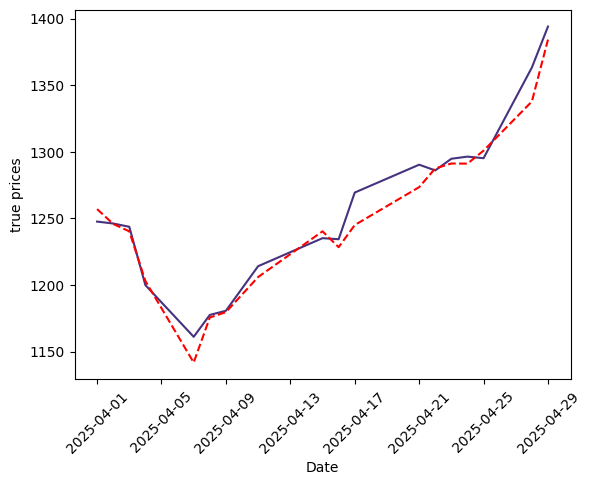

In [15]:
comp_rf = y_true.to_frame(name='true prices')
comp_rf['predictions'] = y_pred_rf
sns.set_palette('viridis')
sns.lineplot(data=comp_rf, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_rf, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### XGB Regression

In [10]:
from xgboost import XGBRegressor
xgb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        objective='reg:squarederror',
        random_state = 42,
        n_jobs=-1
    ))
])
# grid search for XGBR
param_grid = {
    "xgb__n_estimators":[100,300,500],
    "xgb__max_depth":[3,5,7],
    "xgb__learning_rate":[0.01,0.05,0.1],
    "xgb__subsample":[0.7,0.9,1.0],
    "xgb__colsample_bytree":[0.7,0.9,1.0]
}
tscv = TimeSeriesSplit(n_splits=5)
xgb_grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [ ]:
xgb_grid.fit(X,y)
# finding best xgb
best_xgb = xgb_grid.best_estimator_
print("Best parameters: ")
print(xgb_grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: 
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 500, 'xgb__subsample': 1.0}


In [17]:
# running the best xgbr model
y_pred_xgb = best_xgb.predict(X_test)
xgb_mae = mae(y_true, y_pred_xgb)
xgb_rmse = rmse(y_true, y_pred_xgb)
xgb_r2 = r2(y_true, y_pred_xgb)
print(f"MAE: {xgb_mae}")
print(f"RMSE: {xgb_rmse}")
print(f"R2: {xgb_r2}")

MAE: 8.700425889756945
RMSE: 12.18998127910486
R2: 0.9585311399971996


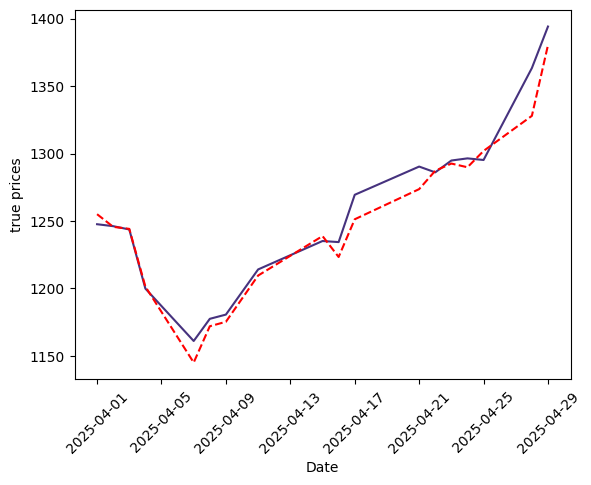

In [18]:
comp_xgb = y_true.to_frame(name='true prices')
comp_xgb['predictions'] = y_pred_xgb
sns.set_palette('viridis')
sns.lineplot(data=comp_xgb, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_xgb, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### Comparing model performance

  models        MAE       RMSE        R2
0     LR   4.824803   6.753846  0.987270
1    SVR  12.524229  15.031597  0.936944
2     RF   8.356678  11.351190  0.964042
3   XGBR   8.700426  12.189981  0.958531


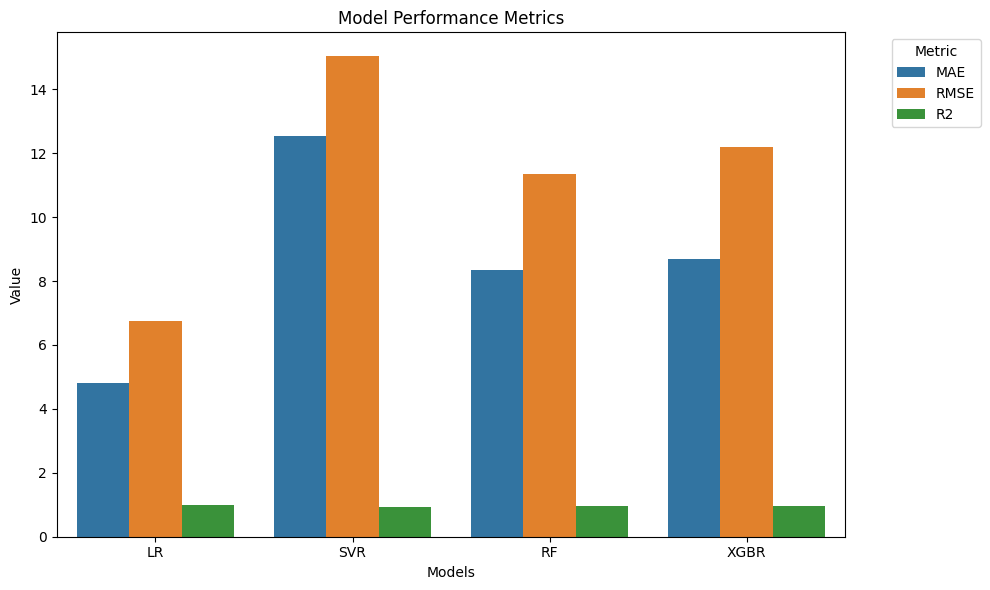

In [19]:
perf = {
    "models":['LR', 'SVR' ,'RF', 'XGBR'],
    "MAE":[reg_mae, svr_mae,rf_mae, xgb_mae],
    "RMSE":[reg_rmse, svr_rmse,rf_rmse, xgb_rmse],
    "R2":[reg_r2, svr_r2,rf_r2, xgb_r2]
}
perf = pd.DataFrame(perf)
print(perf.head())
# melting for plotting
perf.reset_index()
perf = perf.melt(id_vars='models', var_name='Metric', value_name='Value')
# plotting
plt.figure(figsize=(10, 6))

# Plotting with hue for grouping and a high-contrast palette
sns.barplot(
    data=perf, 
    x='models', 
    y='Value', 
    hue='Metric', 
    palette='tab10'
)

plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.xlabel('Models')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## Section 2: Experimenting with 'Close' Price and "Momentum" as target variable

**Momentum** is defined as the change in stock price over a period of time, say 20 days, given by $M(S_t,m) = S_t - S_{t-m} $ where m denotes the window period and is also known as "lag".

In [20]:
# generating momentum
df['momentum'] = df['Close']-df['Close'].shift(20)
df_m = df.dropna().copy()    # dropna to remove the first 20 entries with no momentum
df_m.head()

,Close,High,Low,Open,Volume,momentum
Date,,,,,,
2018-04-03,397.359192,398.308916,391.042441,393.582410,13922126,-21.578522
2018-04-04,395.305115,402.770363,394.046188,399.634074,14214534,-12.898529
2018-04-05,401.180115,401.975237,399.103979,399.810758,8527915,-1.170563
2018-04-06,402.416962,405.729938,399.766592,401.091777,9664888,9.386810
2018-04-09,404.625641,405.950855,403.101683,403.101683,7813897,2.009857


In [21]:
# setting new feature set and target
X_m = X.loc[df_m.index]        # or rebuild features from df_m directly
y_m = df_m["momentum"]


### Linear Regression

In [22]:
reg.fit(X_m,y_m)
y_m_pred = reg.predict(X_test)
full_price = pd.concat([df["Close"], test["Close"]])
m=24
price_lagged = (
    full_price
    .shift(m)
    .loc[test.index]
)

y_pred_reg_m = price_lagged.values + y_m_pred
# metrics
y_true = test['Close']
reg_mae_m = mae(y_true, y_pred_reg_m)
reg_rmse_m = rmse(y_true, y_pred_reg_m)
reg_r2_m = r2(y_true, y_pred_reg_m)
print(f"MAE: {reg_mae_m}")
print(f"RMSE: {reg_rmse_m}")
print(f"R2: {reg_r2_m}")

MAE: 34.16234912950735
RMSE: 42.30679908552902
R2: 0.5004990076538196


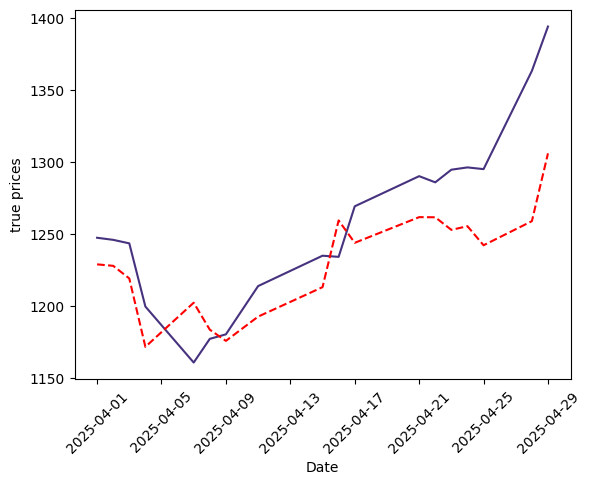

In [23]:
comp_lr = y_true.to_frame(name='true prices')
comp_lr['predictions'] = y_pred_reg_m
sns.set_palette('viridis')
sns.lineplot(data=comp_lr, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_lr, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### SVR

In [24]:
# running grid search
grid.fit(X_m,y_m)
# determining best model
best_svr_m = grid.best_estimator_
print("best parameters for momentum target:")
print(grid.best_params_)

best parameters for momentum target:
{'svr__C': 512.0, 'svr__epsilon': 0.5, 'svr__gamma': 3.814697265625e-06, 'svr__kernel': 'rbf'}


In [25]:
# predicting using SVR
m_pred_svr = best_svr_m.predict(X_test)

y_pred_svr_m = price_lagged.values + m_pred_svr
# metrics
svr_mae_m = mae(y_true, y_pred_svr_m)
svr_rmse_m = rmse(y_true, y_pred_svr_m)
svr_r2_m = r2(y_true, y_pred_svr_m)
print(f"MAE: {svr_mae_m}")
print(f"RMSE: {svr_rmse_m}")
print(f"R2: {svr_r2_m}")

MAE: 40.63927232854363
RMSE: 51.183832152596636
R2: 0.2688918648261197


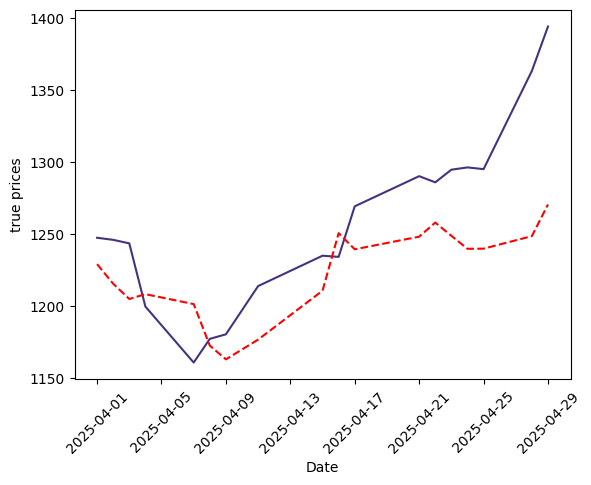

In [26]:
comp_svr = y_true.to_frame(name='true prices')
comp_svr['predictions'] = y_pred_svr_m
sns.set_palette('viridis')
sns.lineplot(data=comp_svr, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_svr, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### Random Forest

In [27]:
rf = RandomForestRegressor(
    random_state=100,
    n_jobs=-1    
)
param_grid = {
    "n_estimators":[200,300,500],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2,5,10],
    "min_samples_leaf": [1,5,10],
    "max_features": ['sqrt', 0.5]
}
tscv = TimeSeriesSplit(n_splits=5)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_m, y_m)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'max_features': ['sqrt', 0.5],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 300, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [28]:
best_rf_m = grid_rf.best_estimator_
print('best params:')
print(grid_rf.best_params_)
# forecasting
m_pred_rf = best_rf_m.predict(X_test)
y_pred_rf_m = price_lagged.values + m_pred_rf
# metrics
rf_mae_m = mae(y_true, y_pred_rf_m)
rf_rmse_m = rmse(y_true, y_pred_rf_m)
rf_r2_m = r2(y_true, y_pred_rf_m)
print(f"MAE: {rf_mae_m}")
print(f"RMSE: {rf_rmse_m}")
print(f"R2: {rf_r2_m}")

best params:
{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300}
MAE: 33.05857438481252
RMSE: 49.153147515296645
R2: 0.325753523802215


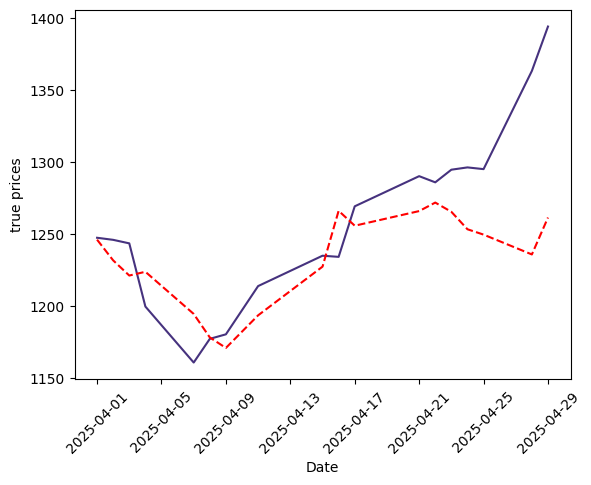

In [29]:
comp_rf = y_true.to_frame(name='true prices')
comp_rf['predictions'] = y_pred_rf_m
sns.set_palette('viridis')
sns.lineplot(data=comp_rf, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_rf, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### XGB Regressor

In [30]:
xgb_grid.fit(X_m,y_m)
# best model
best_xgb_m = xgb_grid.best_estimator_
print("Best parameters: ")
print(xgb_grid.best_params_)
# forecasting
m_pred_xgb = best_xgb_m.predict(X_test)
y_pred_xgb_m = price_lagged.values + m_pred_xgb
# metrics
xgb_mae_m = mae(y_true, y_pred_xgb_m)
xgb_rmse_m = rmse(y_true, y_pred_xgb_m)
xgb_r2_m = r2(y_true, y_pred_xgb_m)
print(f"MAE: {xgb_mae_m}")
print(f"RMSE: {xgb_rmse_m}")
print(f"R2: {xgb_r2_m}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: 
{'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.7}
MAE: 36.28472746743096
RMSE: 48.3151933732217
R2: 0.3485464374358861


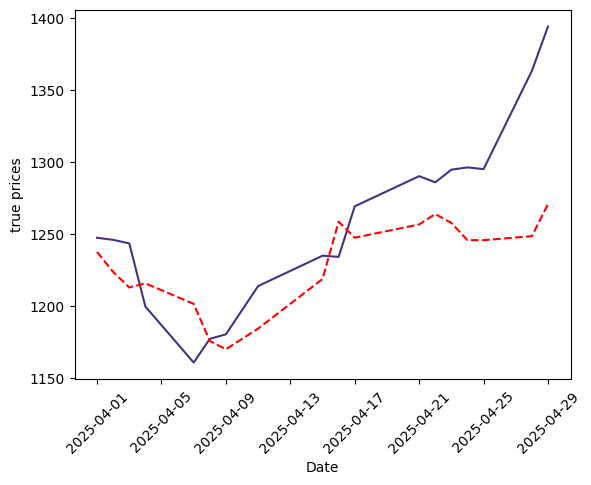

In [31]:
comp_xgb = y_true.to_frame(name='true prices')
comp_xgb['predictions'] = y_pred_xgb_m
sns.set_palette('viridis')
sns.lineplot(data=comp_xgb, x='Date', y='true prices', sort=False)
sns.lineplot(data=comp_xgb, x='Date', y='predictions', linestyle='--', color='red',sort=False)
plt.xticks(rotation=45)
plt.show()

### Comparing performance

  models        MAE       RMSE        R2
0     LR  34.162349  42.306799  0.500499
1    SVR  40.639272  51.183832  0.268892
2     RF  33.058574  49.153148  0.325754
3   XGBR  36.284727  48.315193  0.348546


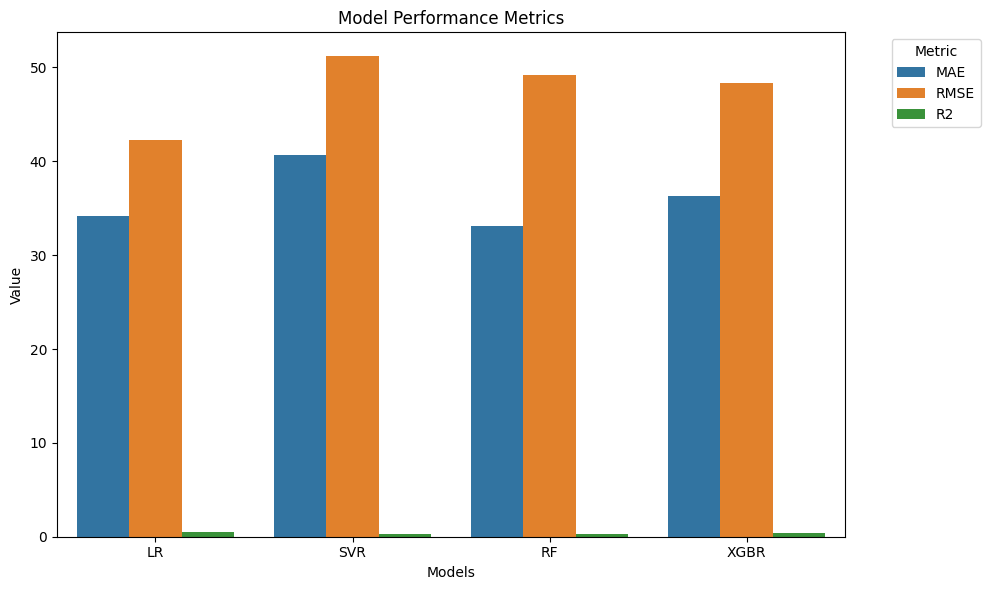

In [32]:
perf = {
    "models":['LR', 'SVR' ,'RF', 'XGBR'],
    "MAE":[reg_mae_m, svr_mae_m,rf_mae_m, xgb_mae_m],
    "RMSE":[reg_rmse_m, svr_rmse_m,rf_rmse_m, xgb_rmse_m],
    "R2":[reg_r2_m, svr_r2_m,rf_r2_m, xgb_r2_m]
}
perf = pd.DataFrame(perf)
print(perf.head())
# melting for plotting
perf.reset_index()
perf = perf.melt(id_vars='models', var_name='Metric', value_name='Value')
# plotting
plt.figure(figsize=(10, 6))

# Plotting with hue for grouping and a high-contrast palette
sns.barplot(
    data=perf, 
    x='models', 
    y='Value', 
    hue='Metric', 
    palette='tab10'
)

plt.title('Model Performance Metrics')
plt.ylabel('Value')
plt.xlabel('Models')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Section 3: How different features affect learning

Five different blocks of features were studied one-by-one to understand how they affect the predictions. These blocks are –
| Block  | Features included                   | Description of the block                                                                                                                  |
| ------ | ----------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------- |
| **B1** | Closeₜ₋₁, Closeₜ₋₂                  | Minimal price memory using only the most recent closing prices to test whether very short-term dependence exists.                         |
| **B2** | 1-day return, 5-day return          | Uses price changes instead of levels to reduce scale effects and introduce basic stationarity.                                            |
| **B3** | B2 + MA(5), MA(20), EMA(5), EMA(20) | Adds smoothed trend information at short and medium horizons to capture underlying price direction.                                       |
| **B4** | B3 + distance from trend            | Encodes how far the current price deviates from its short- and medium-term trends, capturing overextension and mean-reversion tendencies. |
| **B5** | B4 + Volume dynamics                | Incorporates trading activity through relative and changing volume to reflect market participation and confirmation of price movements.   |

*MA means Moving Average*

### Block 1

In [11]:
b1 = pd.DataFrame(df['Close'])
b1['t-1'] = df['Close'].shift(1)
b1['t-2'] = df['Close'].shift(2)
# fixing The NaNs
b1.fillna(0, inplace=True)
b1.head()

,Close,t-1,t-2
Date,,,
2018-03-01,418.937714,0.000000,0.000000
2018-03-05,408.203613,418.937714,0.000000
2018-03-06,402.350708,408.203613,418.937714
2018-03-07,393.030182,402.350708,408.203613
2018-03-08,402.615723,393.030182,402.350708


In [12]:
# splitting target and features
X1 = b1.drop(columns='Close')
y1 = b1['Close']
# preparing X_test
test_b1 = pd.DataFrame()
test_b1['t-1'] = test['Close'].shift(1) 
test_b1['t-2'] = test['Close'].shift(2)
test_b1.fillna(0, inplace=True)
test_b1.head()

,t-1,t-2
Date,,
2025-04-01,0.000000,0.000000
2025-04-02,1247.617065,0.000000
2025-04-03,1246.172974,1247.617065
2025-04-04,1243.732666,1246.172974
2025-04-07,1199.907593,1243.732666


#### Linear Regression

In [13]:
class expt:
    def __init__(self, feat, target, test, true):
        self.feat = feat
        self.target = target
        self.test = test
        self.true = true

    def run_reg(self, reg):
        print("------------")
        print("RUNNING LINEAR REGRESSION")
        reg.fit(self.feat, self.target)
        pred = reg.predict(self.test)
        reg_mae = mae(self.true, pred)
        reg_rmse = rmse(self.true, pred)
        reg_r2 = r2(self.true, pred)
        return reg_mae, reg_rmse, reg_r2, pred

    def run_svr(self, grid):
        print("----------")
        print("RUNNING SVR")
        grid.fit(self.feat, self.target)
        best = grid.best_estimator_
        pred = best.predict(self.test)
        _mae = mae(self.true, pred)
        _rmse = rmse(self.true, pred)
        _r2 = r2(self.true, pred)
        return _mae, _rmse, _r2, pred

    def run_rf(self, grid):
        print("----------")
        print("RUNNING RF")
        grid.fit(self.feat, self.target)
        best = grid.best_estimator_
        pred = best.predict(self.test)
        _mae = mae(self.true, pred)
        _rmse = rmse(self.true, pred)
        _r2 = r2(self.true, pred)
        return _mae, _rmse, _r2, pred

    def run_xgbr(self, grid):
        print("----------")
        print("RUNNING XGBR")
        grid.fit(self.feat, self.target)
        best = grid.best_estimator_
        pred = best.predict(self.test)
        _mae = mae(self.true, pred)
        _rmse = rmse(self.true, pred)
        _r2 = r2(self.true, pred)
        return _mae, _rmse, _r2, pred

    def plot_true_vs_pred(self, pred):
        comp = self.true.to_frame(name='true prices')
        comp['predictions'] = pred
        sns.set_palette('viridis')
        sns.lineplot(data=comp, x='Date', y='true prices', sort=False)
        sns.lineplot(data=comp, x='Date', y='predictions', linestyle='--', color='red',sort=False)
        plt.xticks(rotation=45)
        plt.ylabel("Value")
        plt.xlabel("Date")
        plt.show()

    def plot_perf(self, dic, text):
        perf = pd.DataFrame(dic)
        perf.reset_index()
        perf = perf.melt(id_vars='models', var_name='Metric', value_name='Value')
        # plotting
        plt.figure(figsize=(10, 6))
        
        # Plotting with hue for grouping and a high-contrast palette
        sns.barplot(
            data=perf, 
            x='models', 
            y='Value', 
            hue='Metric', 
            palette='tab10'
        )
        
        plt.title('Model Performance Metrics '+text)
        plt.ylabel('Value')
        plt.xlabel('Models')
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

------------
RUNNING LINEAR REGRESSION
MAE: 88.3267678003572
RMSE: 294.22182778262885
R2: -23.158268149674118


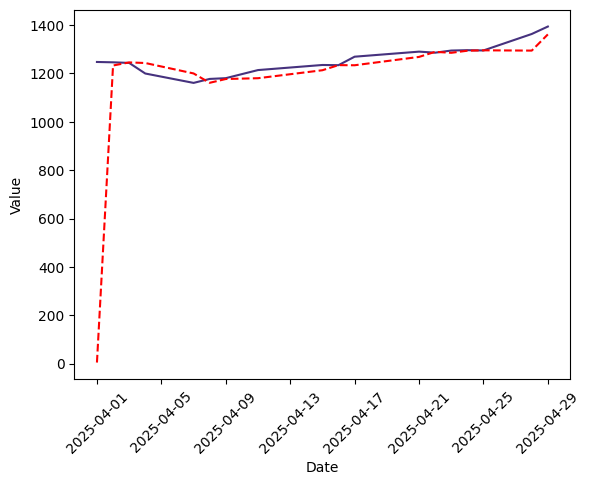

In [23]:
# linear regression
b1 = expt(X1, y1, test_b1,y_true)

reg_mae1, reg_rmse1, reg_r2_1, reg_pred1 = b1.run_reg(reg)
print(f'MAE: {reg_mae1}')
print(f'RMSE: {reg_rmse1}')
print(f"R2: {reg_r2_1}")
b1.plot_true_vs_pred(reg_pred1)

In [15]:
# drop first prediction
y_new = y_true.iloc[1:]
reg_pred1_new = reg_pred1[1:]

# compute metrics
mae_adj_reg = mae(y_new, reg_pred1_new)
rmse_adj_reg = rmse(y_new, reg_pred1_new)
r2_adj_reg = r2(y_new, reg_pred1_new)

# print
print(f'Adjusted MAE: {mae_adj_reg}')
print(f'Adjusted RMSE: {rmse_adj_reg}')
print(f'Adjusted R2: {r2_adj_reg}')


Adjusted MAE: 20.403213199123616
Adjusted RMSE: 27.737731576400435
Adjusted R2: 0.796907875863904


Note that the predicitons are close except for the very first prediciton. B1 fails on the first point because it has almost no past information at the train–test boundary.

----------
RUNNING SVR
MAE: 119.05002308095033
RMSE: 315.59472391945394
R2: -26.795563793039207


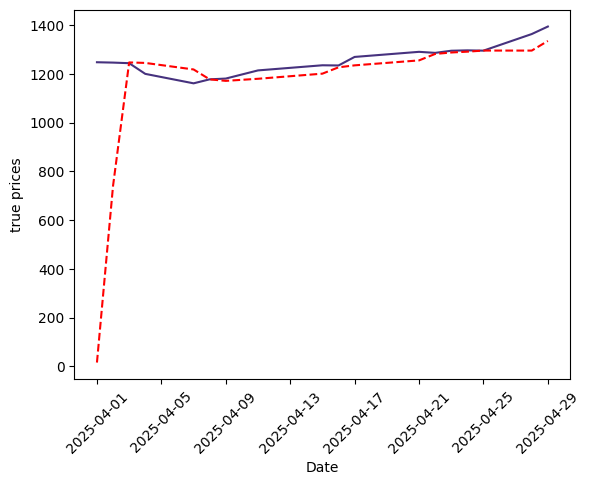

In [16]:
# svr
svr_mae1, svr_rmse1, svr_r2_1, svr_pred1 = b1.run_svr(grid)
print(f'MAE: {svr_mae1}')
print(f'RMSE: {svr_rmse1}')
print(f"R2: {svr_r2_1}")
b1.plot_true_vs_pred(svr_pred1)

In [17]:
# drop first two prediction
y_new = y_true.iloc[2:]
svr_pred1_new = svr_pred1[2:]

# compute metrics
mae_adj_svr = mae(y_new, svr_pred1_new)
rmse_adj_svr = rmse(y_new, svr_pred1_new)
r2_adj_svr = r2(y_new, svr_pred1_new)

# print
print(f'Adjusted MAE: {mae_adj_svr}')
print(f'Adjusted RMSE: {rmse_adj_svr}')
print(f'Adjusted R2: {r2_adj_svr}')


Adjusted MAE: 25.310761817575823
Adjusted RMSE: 33.929689602517406
Adjusted R2: 0.7133511072371772


For SVR, first two predictions are off because SVR needs a couple of points to re-enter familiar feature space; B1 doesn’t give it enough context at the boundary.

----------
RUNNING RF
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
MAE: 88.7861111880795
RMSE: 215.18722463249668
R2: -11.922572812401379


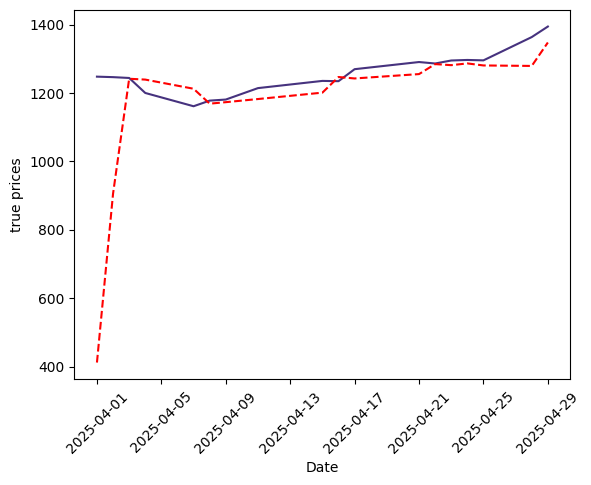

In [18]:
# rf
rf_mae1, rf_rmse1, rf_r2_1, rf_pred1 = b1.run_rf(grid_rf)
print(f'MAE: {rf_mae1}')
print(f'RMSE: {rf_rmse1}')
print(f"R2: {rf_r2_1}")
b1.plot_true_vs_pred(rf_pred1)

In [19]:
# drop first two predictions
rf_pred1_new = rf_pred1[2:]

# compute metrics
mae_adj_rf = mae(y_new, rf_pred1_new)
rmse_adj_rf = rmse(y_new, rf_pred1_new)
r2_adj_rf = r2(y_new, rf_pred1_new)

# print
print(f'Adjusted MAE for RF: {mae_adj_rf}')
print(f'Adjusted RMSE for RF: {rmse_adj_rf}')
print(f'Adjusted R2 for RF: {r2_adj_rf}')


Adjusted MAE for RF: 26.33325327897535
Adjusted RMSE for RF: 33.93924551043876
Adjusted R2 for RF: 0.7131896217542342


First two predictions by RF are also off because the first few test points fall into tree regions the forest has never seen before.

----------
RUNNING XGBR
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 102.60769653320312
RMSE: 234.72882152654924
R2: -14.376194219751413


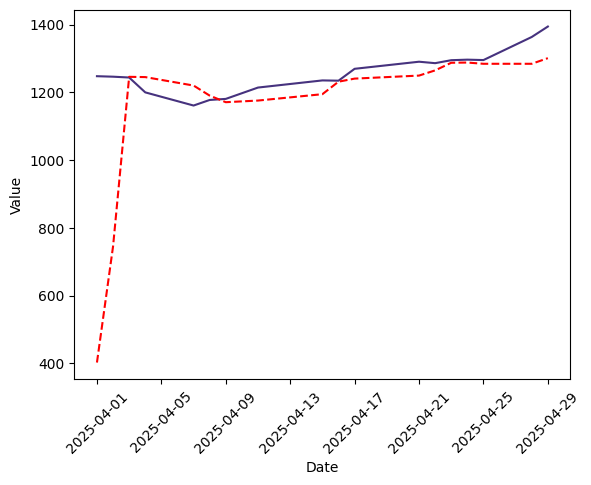

In [24]:
# xgbr
xgb_mae1, xgb_rmse1, xgb_r2_1, xgb_pred1 = b1.run_xgbr(xgb_grid)
print(f'MAE: {xgb_mae1}')
print(f'RMSE: {xgb_rmse1}')
print(f"R2: {xgb_r2_1}")
b1.plot_true_vs_pred(xgb_pred1)

In [21]:
# drop first two predictions
y_new = y_true.iloc[2:]
xgb_pred1_new = xgb_pred1[2:]

# compute metrics
mae_adj_xgb = mae(y_new, xgb_pred1_new)
rmse_adj_xgb = rmse(y_new, xgb_pred1_new)
r2_adj_xgb = r2(y_new, xgb_pred1_new)

# print
print(f'Adjusted MAE for XGBR: {mae_adj_xgb}')
print(f'Adjusted RMSE for XGBR: {rmse_adj_xgb}')
print(f'Adjusted R2 for XGBR: {r2_adj_xgb}')

Adjusted MAE for XGBR: 26.333253278975363
Adjusted RMSE for XGBR: 33.93924551043876
Adjusted R2 for XGBR: 0.7131896217542343


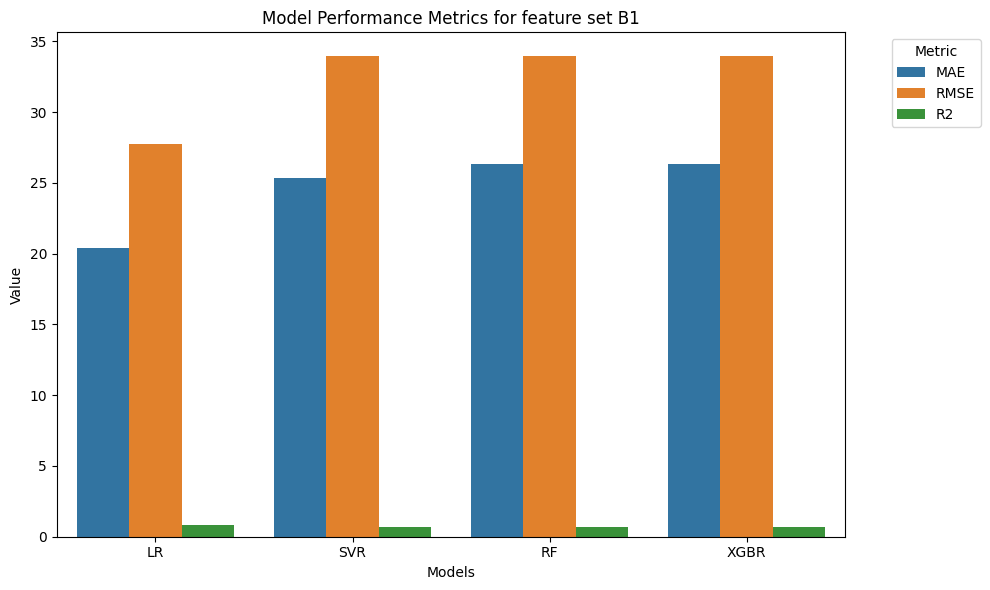

In [22]:
# comparing performance
perf1 = {
    "models": ['LR', 'SVR', 'RF', 'XGBR'],
    "MAE":   [mae_adj_reg, mae_adj_svr, mae_adj_rf, mae_adj_xgb],
    "RMSE":  [rmse_adj_reg, rmse_adj_svr, rmse_adj_rf, rmse_adj_xgb],
    "R2":    [r2_adj_reg, r2_adj_svr, r2_adj_rf, r2_adj_xgb]
}

b1.plot_perf(perf1,"for feature set B1")

### Block 2

In [19]:
b_2 = pd.DataFrame(df['Close'])
b_2['1-day return'] = df['Close'].pct_change(1)
b_2['5-day return'] = df['Close'].pct_change(5)
b_2.fillna(0,inplace=True)
# splitting target and features
X2 = b_2.drop(columns='Close')
y2 = b_2['Close']
# preparing X_test
test_b2 = pd.DataFrame()
test_b2['1-day return'] = test['Close'].pct_change(1) 
test_b2['5-day return'] = test['Close'].pct_change(2)
test_b2.fillna(0, inplace=True)
b_2.tail()

,Close,1-day return,5-day return
Date,,,
2025-03-24,1296.920166,0.020175,0.051055
2025-03-25,1280.336426,-0.012787,0.037616
2025-03-26,1267.985840,-0.009646,0.020767
2025-03-27,1273.115234,0.004045,0.007131
2025-03-28,1270.027588,-0.002425,-0.000979


------------
RUNNING LINEAR REGRESSION
MAE: 297.2324208528736
RMSE: 303.4893807774902
R2: -24.704136470770806


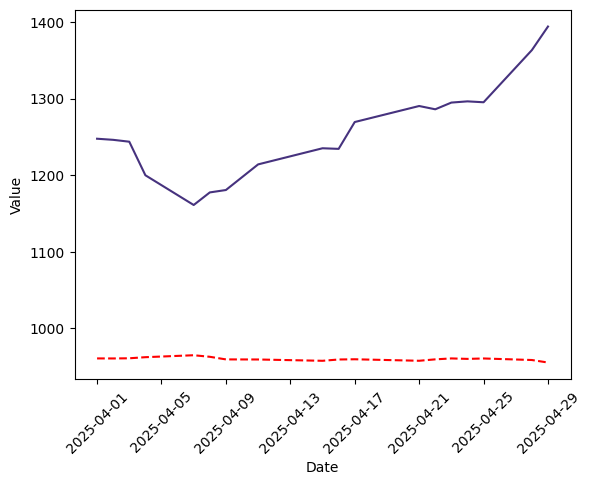

In [27]:
# linear regression
b2 = expt(X2, y2, test_b2,y_true)

reg_mae2, reg_rmse2, reg_r2_2, reg_pred2 = b2.run_reg(reg)
print(f'MAE: {reg_mae2}')
print(f'RMSE: {reg_rmse2}')
print(f"R2: {reg_r2_2}")
b2.plot_true_vs_pred(reg_pred2)
# print(y_true)
# print(reg_pred2)

----------
RUNNING SVR
MAE: 224.1078407587887
RMSE: 248.82507407491158
R2: -16.278431013244163


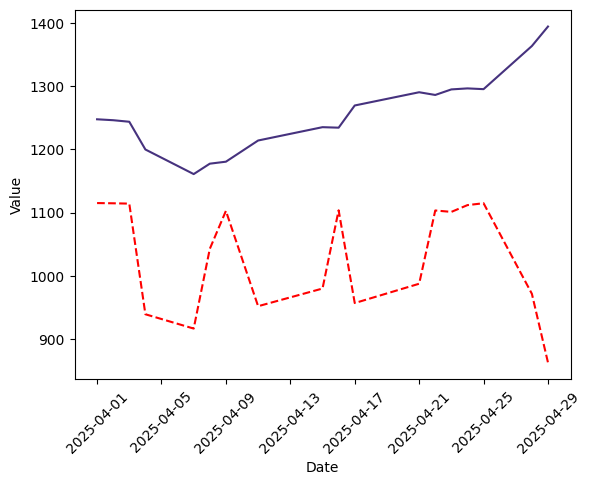

In [22]:
# svr
svr_mae2, svr_rmse2, svr_r2_2, svr_pred2 = b2.run_svr(grid)
print(f'MAE: {svr_mae2}')
print(f'RMSE: {svr_rmse2}')
print(f"R2: {svr_r2_2}")
b2.plot_true_vs_pred(svr_pred2)

In [ ]:
print(y_true)
svr_pred2

----------
RUNNING RF
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
MAE: 284.3210437918971
RMSE: 294.0682642033274
R2: -23.133056818369976


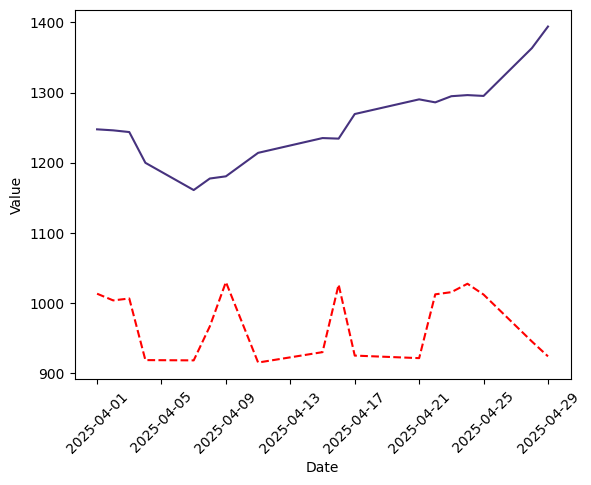

In [23]:
# rf
rf_mae2, rf_rmse2, rf_r2_2, rf_pred2 = b2.run_rf(grid_rf)
print(f'MAE: {rf_mae2}')
print(f'RMSE: {rf_rmse2}')
print(f"R2: {rf_r2_2}")
b2.plot_true_vs_pred(rf_pred2)

----------
RUNNING XGBR
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 277.2397969563802
RMSE: 287.30830693006305
R2: -22.03628193482699


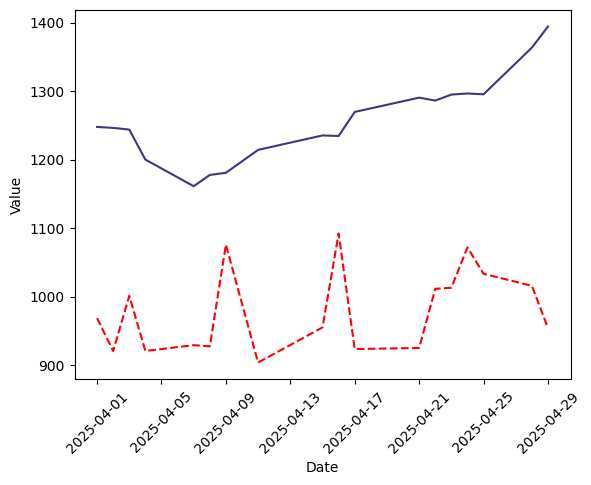

In [28]:
xgb_mae2, xgb_rmse2, xgb_r2_2, xgb_pred2 = b2.run_xgbr(xgb_grid)
print(f'MAE: {xgb_mae2}')
print(f'RMSE: {xgb_rmse2}')
print(f"R2: {xgb_r2_2}")
b2.plot_true_vs_pred(xgb_pred2)

### BLOCK 3

In [21]:
b_3 = b_2.copy()
b_3['MA5'] = df['Close'].rolling(5).mean()
b_3['MA20'] = df['Close'].rolling(20).mean()
b_3['EMA5'] = df['Close'].ewm(span=5).mean()
b_3['EMA20'] = df['Close'].ewm(span=20).mean()

b_3 = pd.concat([b_2, b_3], axis=0)
b_3.fillna(0, inplace=True)

X3 = b_3.drop(columns='Close')
y3 = b_3['Close']

test_b3 = test_b2.copy()
test_b3['Close'] = test['Close']
test_b3['MA5'] = test['Close'].rolling(5).mean()
test_b3['MA20'] = test['Close'].rolling(20).mean()
test_b3['EMA5'] = test['Close'].ewm(span=5).mean()
test_b3['EMA20'] = test['Close'].ewm(span=20).mean()
test_b3.fillna(0, inplace=True)

X_test3 = test_b3.drop(columns='Close')
b_3.tail()

,Close,1-day return,5-day return,MA5,MA20,EMA5,EMA20
Date,,,,,,,
2025-03-24,1296.920166,0.020175,0.051055,1261.680933,1224.367487,1268.745535,1239.579757
2025-03-25,1280.336426,-0.012787,0.037616,1270.963867,1227.221088,1272.609165,1243.461345
2025-03-26,1267.985840,-0.009646,0.020767,1276.123267,1230.134454,1271.068057,1245.797011
2025-03-27,1273.115234,0.004045,0.007131,1277.926050,1233.829694,1271.750449,1248.398746
2025-03-28,1270.027588,-0.002425,-0.000979,1277.677051,1237.216168,1271.176162,1250.458636


------------
RUNNING LINEAR REGRESSION
MAE: 1773.9091327577032
RMSE: 1775.4602578465908
R2: -878.706761816285


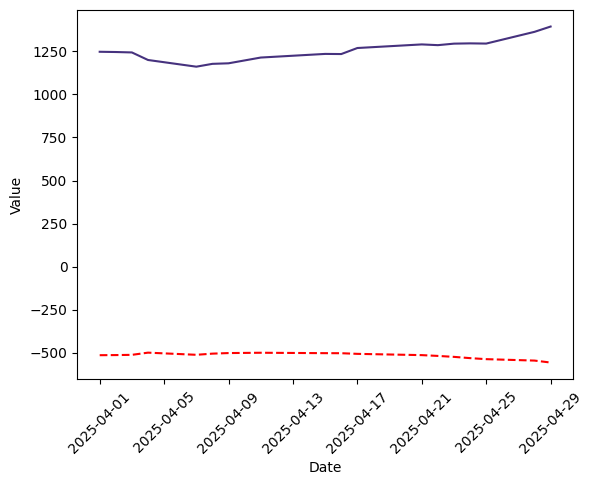

In [29]:
# linear regression
b3 = expt(X3, y3, X_test3,y_true)

reg_mae3, reg_rmse3, reg_r2_3, reg_pred3 = b3.run_reg(reg)
print(f'MAE: {reg_mae3}')
print(f'RMSE: {reg_rmse3}')
print(f"R2: {reg_r2_3}")
b3.plot_true_vs_pred(reg_pred3)


----------
RUNNING SVR
MAE: 224.1078407587887
RMSE: 248.82507407491158
R2: -16.278431013244163


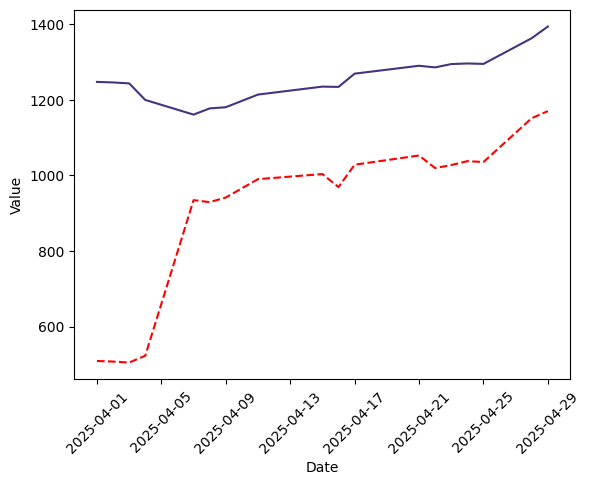

In [48]:
svr_mae3, svr_rmse3, svr_r2_3, svr_pred3 = b3.run_svr(grid)
print(f'MAE: {svr_mae2}')
print(f'RMSE: {svr_rmse2}')
print(f"R2: {svr_r2_2}")
b3.plot_true_vs_pred(svr_pred3)

----------
RUNNING RF
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
MAE: 71.06624152223748
RMSE: 104.83441823654597
R2: -2.0670707783717908


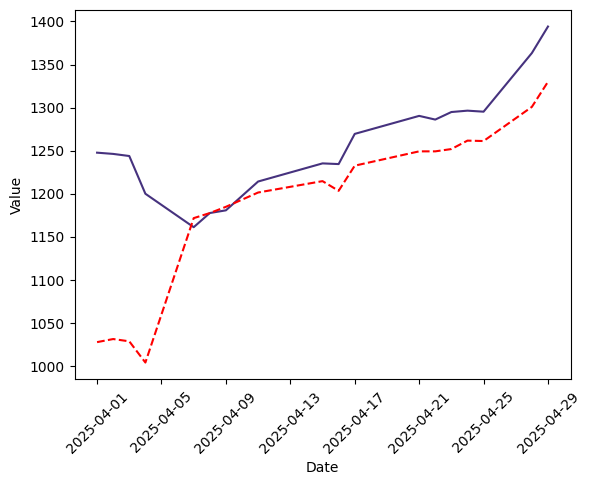

In [49]:
# rf
rf_mae3, rf_rmse3, rf_r2_3, rf_pred3 = b3.run_rf(grid_rf)
print(f'MAE: {rf_mae3}')
print(f'RMSE: {rf_rmse3}')
print(f"R2: {rf_r2_3}")
b3.plot_true_vs_pred(rf_pred3)

----------
RUNNING XGBR
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 30.35018581814236
RMSE: 37.73945824983138
R2: 0.6025272656931489


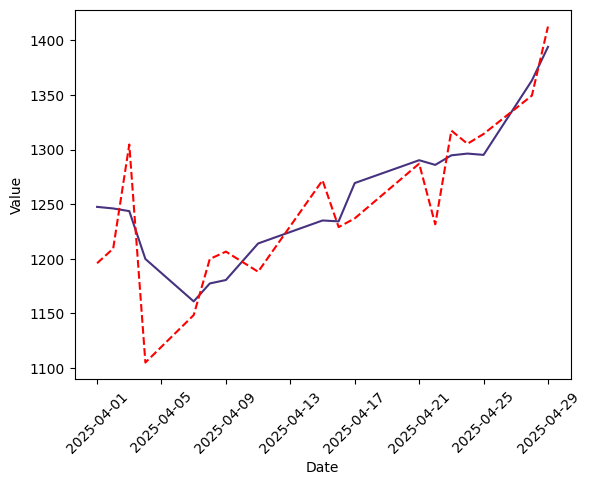

In [30]:
xgb_mae3, xgb_rmse3, xgb_r2_3, xgb_pred3 = b3.run_xgbr(xgb_grid)
print(f'MAE: {xgb_mae3}')
print(f'RMSE: {xgb_rmse3}')
print(f"R2: {xgb_r2_3}")
b3.plot_true_vs_pred(xgb_pred3)

### BLOCK 4

In [16]:
b_4 = b_3.copy()
b_4['dist5'] = (b_3['Close']-b_3['MA5'])/b_3['MA5']
b_4['dist20'] = (b_3['Close']-b_3['MA20'])/b_3['MA20']
b_4.fillna(0, inplace=True)
b_4.replace([np.inf, -np.inf], 0, inplace=True)

X4 = b_4.drop(columns='Close')
y4 = b_4['Close']

test_b4 = test_b3.copy()
test_b4['dist5'] = (test_b3['Close']-test_b3['MA5'])/test_b3['MA5']
test_b4['dist20'] = (test_b3['Close']-test_b3['MA20'])/test_b3['MA20']
test_b4.fillna(0, inplace=True)
test_b4.replace([np.inf, -np.inf], 0, inplace=True)

X_test4 = test_b4.drop(columns='Close')
b_4.tail()

,Close,1-day return,5-day return,MA5,MA20,EMA5,EMA20,dist5,dist20
Date,,,,,,,,,
2025-03-24,1296.920166,0.020175,0.051055,1261.680933,1224.367487,1268.745535,1239.579757,0.027930,0.059257
2025-03-25,1280.336426,-0.012787,0.037616,1270.963867,1227.221088,1272.609165,1243.461345,0.007374,0.043281
2025-03-26,1267.985840,-0.009646,0.020767,1276.123267,1230.134454,1271.068057,1245.797011,-0.006377,0.030770
2025-03-27,1273.115234,0.004045,0.007131,1277.926050,1233.829694,1271.750449,1248.398746,-0.003765,0.031840
2025-03-28,1270.027588,-0.002425,-0.000979,1277.677051,1237.216168,1271.176162,1250.458636,-0.005987,0.026520


------------
RUNNING LINEAR REGRESSION
MAE: 1611.169077197976
RMSE: 1614.4988104734264
R2: -726.4304525373149


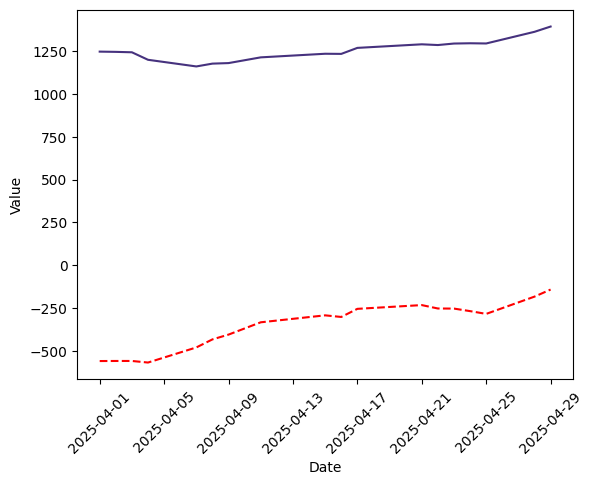

In [31]:
# linear regression
b4 = expt(X4, y4, X_test4,y_true)

reg_mae4, reg_rmse4, reg_r2_4, reg_pred4 = b4.run_reg(reg)
print(f'MAE: {reg_mae4}')
print(f'RMSE: {reg_rmse4}')
print(f"R2: {reg_r2_4}")
b4.plot_true_vs_pred(reg_pred4)

----------
RUNNING SVR
MAE: 224.1078407587887
RMSE: 248.82507407491158
R2: -16.278431013244163


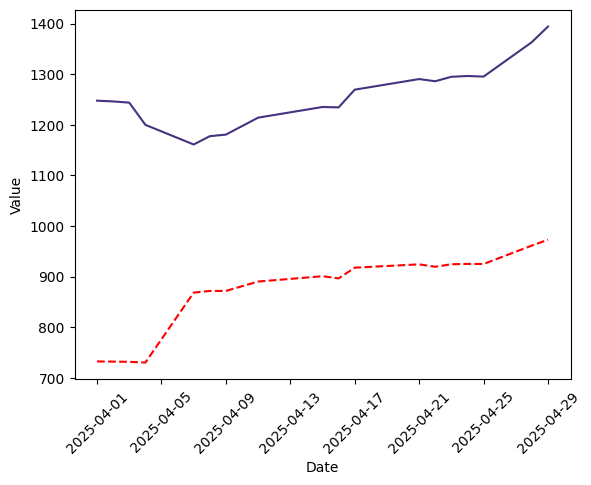

In [64]:
# svr
svr_mae4, svr_rmse4, svr_r2_4, svr_pred4 = b4.run_svr(grid)
print(f'MAE: {svr_mae2}')
print(f'RMSE: {svr_rmse2}')
print(f"R2: {svr_r2_2}")
b4.plot_true_vs_pred(svr_pred4)

----------
RUNNING RF
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
MAE: 83.19569565301153
RMSE: 117.0468227505599
R2: -2.82327271736799


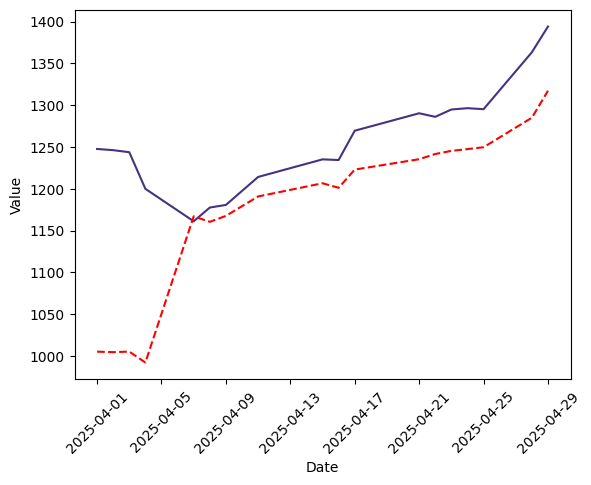

In [65]:
# rf
rf_mae4, rf_rmse4, rf_r2_4, rf_pred4 = b4.run_rf(grid_rf)
print(f'MAE: {rf_mae4}')
print(f'RMSE: {rf_rmse4}')
print(f"R2: {rf_r2_4}")
b4.plot_true_vs_pred(rf_pred4)

----------
RUNNING XGBR
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 36.118381076388886
RMSE: 42.45201043678804
R2: 0.49706420781180216


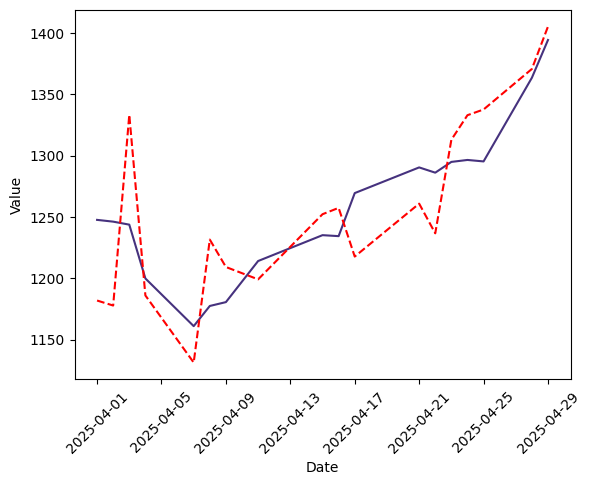

In [32]:
# xgb
xgb_mae4, xgb_rmse4, xgb_r2_4, xgb_pred4 = b4.run_xgbr(xgb_grid)
print(f'MAE: {xgb_mae4}')
print(f'RMSE: {xgb_rmse4}')
print(f"R2: {xgb_r2_4}")
b4.plot_true_vs_pred(xgb_pred4)

### BLOCK 5

In [33]:
b_5 = b_4.copy()
b_5['vol change 1-day'] = df['Volume'].pct_change()
b_5['vol MA'] = df['Volume'].rolling(20).mean()
b_5.fillna(0, inplace=True)
b_5.replace([np.inf, -np.inf], 0, inplace=True)
# preparing features and target
X5 = b_5.drop(columns='Close')
y5 = b_5['Close']

test_b5 = test_b4.copy()
test_b5['vol change 1-day'] = test['Volume'].pct_change()
test_b5['vol MA'] = test['Volume'].rolling(20).mean()
test_b5.fillna(0, inplace=True)
test_b5.replace([np.inf, -np.inf], 0, inplace=True)
X_test5 = test_b5.drop(columns='Close')
b_5.tail()

,Close,1-day return,5-day return,MA5,MA20,EMA5,EMA20,dist5,dist20,vol change 1-day,vol MA
Date,,,,,,,,,,,
2025-03-24,1296.920166,0.020175,0.051055,1261.680933,1224.367487,1268.745535,1239.579757,0.027930,0.059257,-0.068016,13171659.90
2025-03-25,1280.336426,-0.012787,0.037616,1270.963867,1227.221088,1272.609165,1243.461345,0.007374,0.043281,-0.324416,13512153.60
2025-03-26,1267.985840,-0.009646,0.020767,1276.123267,1230.134454,1271.068057,1245.797011,-0.006377,0.030770,-0.119525,13757266.05
2025-03-27,1273.115234,0.004045,0.007131,1277.926050,1233.829694,1271.750449,1248.398746,-0.003765,0.031840,0.244586,13931059.75
2025-03-28,1270.027588,-0.002425,-0.000979,1277.677051,1237.216168,1271.176162,1250.458636,-0.005987,0.026520,0.207550,14262955.45


------------
RUNNING LINEAR REGRESSION
MAE: 2057.739733687401
RMSE: 2058.6095068630884
R2: -1181.6710536472929


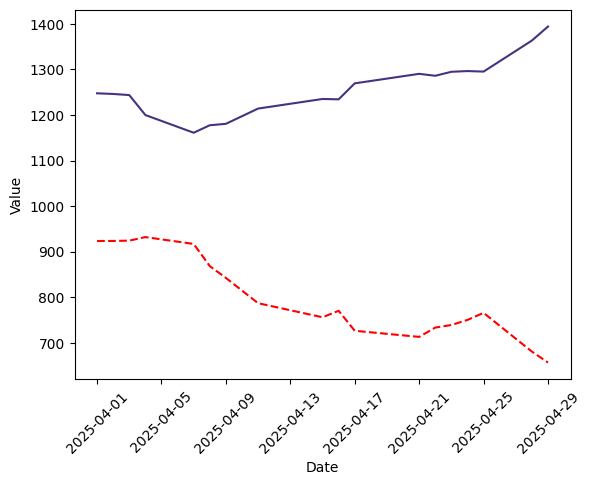

In [34]:
# linear regression
b5 = expt(X5, y5, X_test5,y_true)

reg_mae5, reg_rmse5, reg_r2_5, reg_pred5 = b5.run_reg(reg)
reg_pred5 = abs(reg_pred5)
print(f'MAE: {reg_mae5}')
print(f'RMSE: {reg_rmse5}')
print(f"R2: {reg_r2_5}")
b5.plot_true_vs_pred(reg_pred5)

In [ ]:
# svr
svr_mae5, svr_rmse5, svr_r2_5, svr_pred5 = b5.run_svr(grid)
print(f'MAE: {svr_mae5}')
print(f'RMSE: {svr_rmse5}')
print(f"R2: {svr_r2_5}")
b5.plot_true_vs_pred(svr_pred5)

----------
RUNNING SVR


MAE: 151.5089723120795
RMSE: 166.18005888819823
R2: -6.7067955217646515


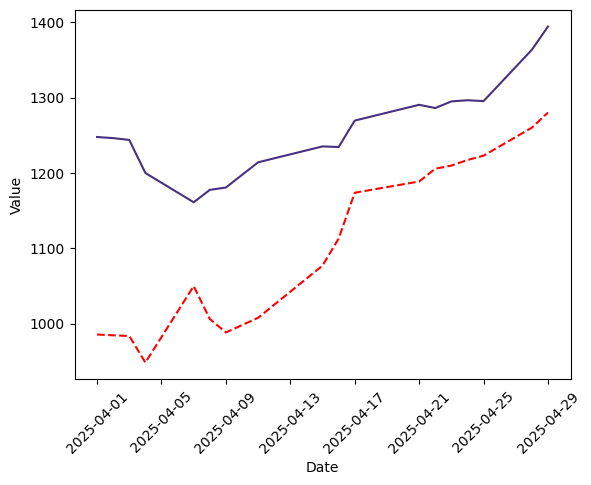

In [21]:
# rf
rf_mae5, rf_rmse5, rf_r2_5, rf_pred5 = b5.run_rf(grid_rf)
print(f'MAE: {rf_mae5}')
print(f'RMSE: {rf_rmse5}')
print(f"R2: {rf_r2_5}")
b5.plot_true_vs_pred(rf_pred5)

----------
RUNNING XGBR
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
MAE: 92.8519049750434
RMSE: 128.87968229489218
R2: -3.635375627340479


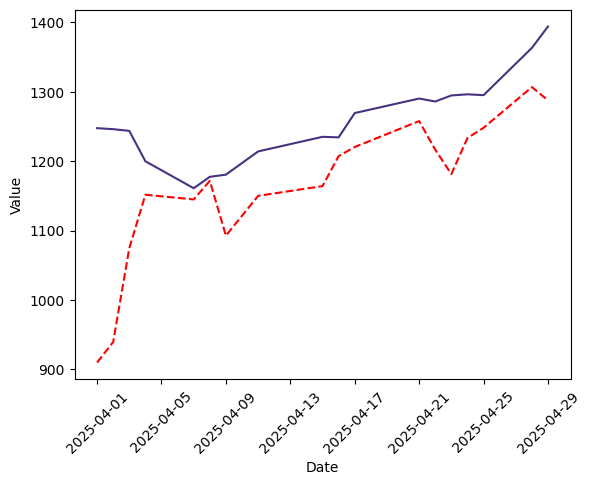

In [35]:
# xgb
xgb_mae5, xgb_rmse5, xgb_r2_5, xgb_pred5 = b5.run_xgbr(xgb_grid)
print(f'MAE: {xgb_mae5}')
print(f'RMSE: {xgb_rmse5}')
print(f"R2: {xgb_r2_5}")
b5.plot_true_vs_pred(xgb_pred5)